In [1]:
import seaborn as sb
sb.set(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.5, color_codes=True)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})
sb.set_context(rc={'lines.markeredgewidth': 1})

## Fitting upper limit of RV amplitude

In [2]:
# https://exofop.ipac.caltech.edu/tess/target.php?id=470381900
Porb = 2.50071474655903, 0.000511482
tc = 2458816.697706, 0.0027523146

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def phase_fold(time, rv_val, rv_err, P, tc=0):
    
    fold = (time-tc) % P
    phase_sort = np.argsort(fold)

    phase_time = fold[phase_sort]
    phase_rv_val = rv_val[phase_sort]
    phase_rv_err = rv_err[phase_sort]
    
    return phase_time, phase_rv_val, phase_rv_err

# band comparison

In [4]:
import pandas as pd

fps ={}
fps['h'] = pd.read_csv("../data/rv/TOI1696_rv_h_new.dat")
fps['yj'] = pd.read_csv("../data/rv/TOI1696_rv_yj_new.dat")
fps['all'] = pd.read_csv("../data/rv/TOI1696_rv_all_new.dat")

In [5]:
import pandas as pd

fp = "../data/rv/TOI1696_rv_h_new.dat"

df = pd.read_csv(fp,
                  skiprows=[1] # <------------------first datapoint is 243 d apart from rest!
                )
df['rv'] = df['rv']*1000
df['rv_err'] = df['rv_err']*1000
df

,bjd,rv,rv_err
0,2.459488e+06,79.955,8.17
1,2.459508e+06,66.788,10.87
2,2.459508e+06,26.116,8.23
3,2.459510e+06,62.113,10.18
4,2.459510e+06,-1.363,8.54
5,2.459515e+06,-1.412,9.39
6,2.459515e+06,-29.998,8.43
7,2.459531e+06,-74.507,9.47
8,2.459589e+06,1.363,9.36


In [6]:
#first data points is 243 days apart from the rest
df.bjd.diff()

0          NaN
1    19.961093
2     0.149916
3     1.825067
4     0.170287
5     4.860434
6     0.198360
7    15.721695
8    57.881201
Name: bjd, dtype: float64

## test dataset
* uncomment below to test RV model

<AxesSubplot:xlabel='bjd'>

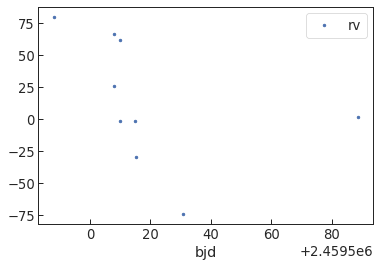

In [7]:
df.plot(x='bjd',y='rv',marker='.',ls='')

<ErrorbarContainer object of 3 artists>

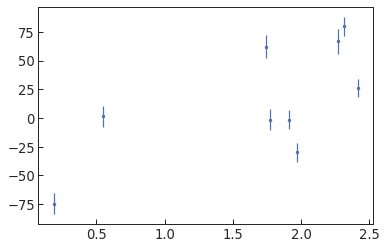

In [8]:
phase_time, phase_rv_val, phase_rv_err = phase_fold(df.bjd.values, 
                                                    df.rv.values, 
                                                    df.rv_err.values, 
                                                    P=Porb[0],
                                                    tc=tc[0]+Porb[0]/2
                                                   ) 
plt.errorbar(phase_time, phase_rv_val, yerr=phase_rv_err, fmt='.')

## periodogram

In [9]:
import pandas as pd
import astropy.units as u
from astropy.timeseries import LombScargle

In [10]:
ls = LombScargle(df['bjd'], df['rv'])

In [11]:
# frequency, power = ls.autopower(minimum_frequency=1/(5*u.d), maximum_frequency=2/u.d)
frequency, power = ls.autopower(minimum_frequency=1/5, maximum_frequency=2)
period = 1/frequency

In [12]:
best_period = period[np.argmax(power)]
best_period

0.9825890343765604

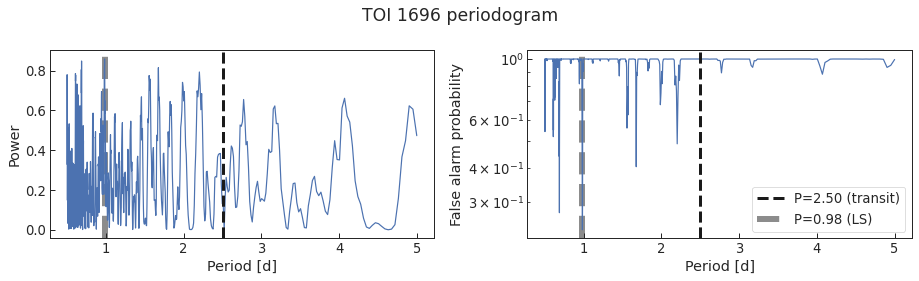

In [13]:
target = 'TOI 1696'

fig, axs = plt.subplots(1, 2, figsize=(13,4))
axs[0].plot(period, power)
axs[1].semilogy(period, ls.false_alarm_probability(power))
[ax.axvline(Porb[0], 0, 1, ls='--', lw=3, c='k', label=f"P={Porb[0]:.2f} (transit)") for ax in axs]
[ax.axvline(best_period, c='k', ls='--', zorder=-1, lw=6, alpha=0.5, label=f"P={best_period:.2f} (LS)") for ax in axs]
plt.legend()
plt.setp(axs, xlabel='Period [d]')
plt.setp(axs[0], ylabel='Power')
plt.setp(axs[1], ylabel='False alarm probability')
fig.suptitle(f'{target} periodogram')
fig.tight_layout()

Periodogram cannot detect the period from transit

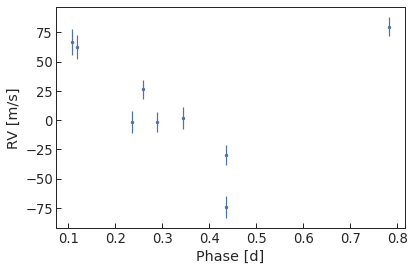

In [14]:
fig, ax = plt.subplots()
ax.errorbar(df['bjd'] % best_period, df['rv'], df['rv_err'], fmt='.')
plt.setp(ax, xlabel='Phase [d]', ylabel='RV [m/s]')
fig.tight_layout()

In [15]:
best_period

0.9825890343765604

## LPF

In [16]:
from pytransit.lpf.rvlpf import RVLPF

lpf = RVLPF(target, 
            nplanets=1, 
            times=df['bjd'].values,#*u.day, 
            rvs=df['rv'].values,#*u.m/u.second, 
            rves=df['rv_err'].values,#*u.m/u.second
           )
lpf.ps

[  0 |G| tc_1           N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p_1            N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| secw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   3 |G| sesw_1         U(a = -1.0, b = 1.0)                     [   -1.00 ..     1.00],
   4 |G| rv_shift_0     N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   5 |G| rv_err_0       U(a = 0.0, b = 1.0)                      [    -inf ..      inf],
   6 |G| rv_k_1         U(a = 0.0, b = 1.0)                      [    0.00 ..      inf],
   7 |G| rv_slope       N(μ = 0.0, σ = 1.0)                      [    -inf ..      inf]]

In [17]:
lpf.rvm??

In [ ]:
# offset = Porb[0]/2
# lpf.set_prior('tc_1', 'NP', tc[0]+offset, tc[1]+offset)  
lpf.set_prior('tc_1', 'NP', 0, 1)
lpf.set_prior('p_1', 'NP', *Porb)
lpf.set_prior('rv_k_1', 'UP', 0.0, 500)        # main parameter of interest
lpf.set_prior('rv_shift_0', 'UP', -50, 50)   # unknown
lpf.set_prior('rv_err_0', 'UP', 0.0, 1)       # jitter term, NP assuming quoted rv err is not underestimated
lpf.set_prior('rv_slope', 'NP', 0, 1)        # essentially fixed
lpf.set_prior('secw_1', 'NP', 0, 0.01)         # essentially fixed, omega=ecc=0
lpf.set_prior('sesw_1', 'NP', 0, 0.01)         # essentially fixed
lpf.ps

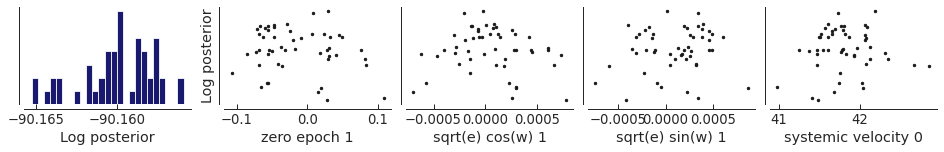

In [19]:
lpf.optimize_global(2000)

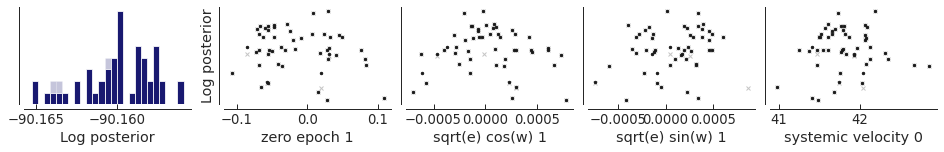

In [20]:
lpf.optimize_global(500)

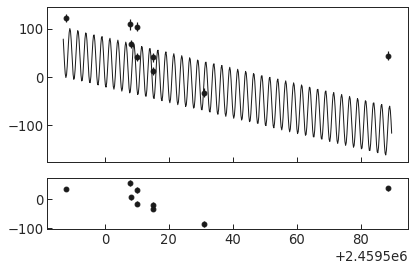

In [21]:
fig = lpf.plot_rv_vs_time(method='de')

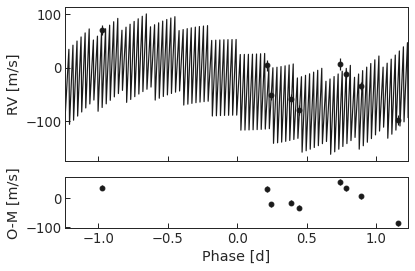

In [22]:
fig = lpf.plot_rv_vs_phase(planet=0, method='de', ntimes=500);

## mcmc

In [23]:
lpf.sample_mcmc(niter=5000, thin=10, repeats=2)

## posterior model

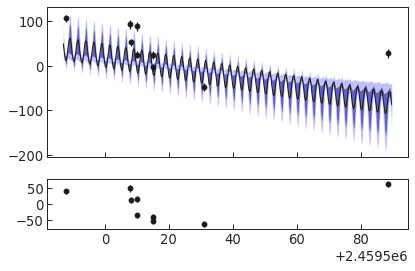

In [24]:
fig = lpf.plot_rv_vs_time(method='mcmc');

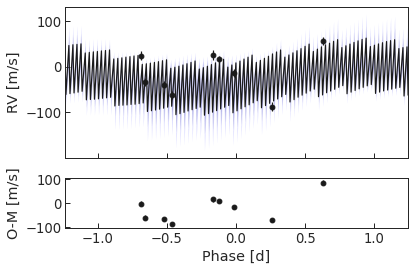

In [25]:
fig = lpf.plot_rv_vs_phase(planet=0, method='mcmc', ntimes=500)
# fig.axes[0].add_patch(Rectangle((-.02, -25), 0.04, 50, fill=False));

## RV amplitude upper limit

In [26]:
df2 = lpf.posterior_samples()
df2['tc_1'] = lpf._tref
df2

,tc_1,p_1,secw_1,sesw_1,rv_shift_0,rv_err_0,rv_k_1,rv_slope
0,2.459519e+06,2.500255,-0.011758,-0.025553,29.107436,4.344462,37.114169,-1.487890
1,2.459519e+06,2.500255,-0.011758,-0.025553,29.107436,4.344462,37.114169,-1.487890
2,2.459519e+06,2.500323,-0.012316,-0.022919,29.575218,4.484238,37.395326,-1.488189
3,2.459519e+06,2.500323,-0.012316,-0.022919,29.575218,4.484238,37.395326,-1.488189
4,2.459519e+06,2.500323,-0.012316,-0.022919,29.575218,4.484238,37.395326,-1.488189
...,...,...,...,...,...,...,...,...
24995,2.459519e+06,2.500570,-0.000821,0.018157,24.097020,6.268427,29.488323,-1.395817
24996,2.459519e+06,2.500511,-0.000843,0.021589,23.892758,6.163813,29.231727,-1.406963
24997,2.459519e+06,2.500511,-0.000843,0.021589,23.892758,6.163813,29.231727,-1.406963
24998,2.459519e+06,2.500511,-0.000843,0.021589,23.892758,6.163813,29.231727,-1.406963


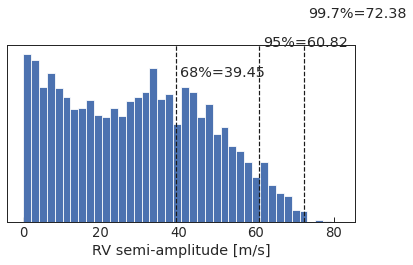

In [27]:
fig, ax = plt.subplots()
ax.hist(df2.rv_k_1, bins=40)
# ax.axvline(np.median(df2.rv_k_1), c='k')
pctls = [68,95,99.7]
vals = np.percentile(df2.rv_k_1, pctls)
i=0
for p,v in zip(pctls,vals):
    ax.axvline(v, 0, 1, ls='--', c='k')
    ax.text(v+1, 1000+i,f"{p}%={v:.2f}")
    i+=200
plt.setp(ax, xlabel='RV semi-amplitude [m/s]', yticks=[])
fig.tight_layout()

In [28]:
lpf.ps.names

['tc_1',
 'p_1',
 'secw_1',
 'sesw_1',
 'rv_shift_0',
 'rv_err_0',
 'rv_k_1',
 'rv_slope']

In [29]:
HALF_PI = 0.5 * np.pi
TWO_PI = 2 * np.pi

def secw(e, w):
    return np.sqrt(e)*cos(w)

def sesw(e, w):
    return np.sqrt(e)*sin(w)

def ecc(secw, sesw):
    return secw**2+sesw**2

def omega(sesw, secw):
    return np.arctan2(sesw, secw)

def rv_model(t, t0, p, e, w, k, offset):    
    """
    M = 2*np.pi/P * (t - tp)
    E = E_sol(e, M)

    f = 2*np.arctan(((1+e)/(1-e))**0.5 * np.tan(E/2))

    rv = K*( np.cos(f)*np.cos(pomega) - np.sin(f)*np.sin(pomega) + gamma + e*np.cos(pomega))
    """
    ta = ta_newton_v(t, t0, p, e, w)
    rv = k * (np.cos(w + ta) + e * np.cos(w)) + offset
    return rv
    
def ta_newton_v(t, t0, p, e, w):
    """
    """
    Ma = mean_anomaly(t, t0, p, e, w)
    Ea = Ma.copy()
    for j in range(len(t)):
        err = 0.05
        k = 0
        while abs(err) > 1e-8 and k<1000:
            err   = Ea[j] - e*np.sin(Ea[j]) - Ma[j]
            Ea[j] = Ea[j] - err/(1.0-e*np.cos(Ea[j]))
            k += 1
    
    sta = np.sqrt(1.0-e**2) * np.sin(Ea)/(1.0-e*np.cos(Ea))
    cta = (np.cos(Ea)-e)/(1.0-e*np.cos(Ea))
    
    return np.arctan2(sta, cta)

def mean_anomaly(t, t0, p, e, w):
    offset = mean_anomaly_offset(e, w)
    Ma = np.mod(TWO_PI * (t - (t0 - offset * p / TWO_PI)) / p, TWO_PI)
    return Ma

def mean_anomaly_offset(e, w):
    mean_anomaly_offset = np.arctan2(np.sqrt(1.0-e**2) * np.sin(HALF_PI - w), e + np.cos(HALF_PI - w))
    mean_anomaly_offset -= e*np.sin(mean_anomaly_offset)
    return mean_anomaly_offset

In [30]:
df2 = lpf.posterior_samples()
df2['tc_1'] = lpf._tref
df2['ecc'] = ecc(df2['secw_1'], df2['sesw_1'])
df2['omega'] = np.rad2deg(omega(df2['secw_1'], df2['sesw_1']))
df2.median()

tc_1          2.459519e+06
p_1           2.500659e+00
secw_1        3.363505e-04
sesw_1       -1.185174e-03
rv_shift_0    2.847775e+01
rv_err_0      5.721001e+00
rv_k_1        2.916147e+01
rv_slope     -1.217506e+00
ecc           1.453060e-04
omega         5.357132e+00
dtype: float64

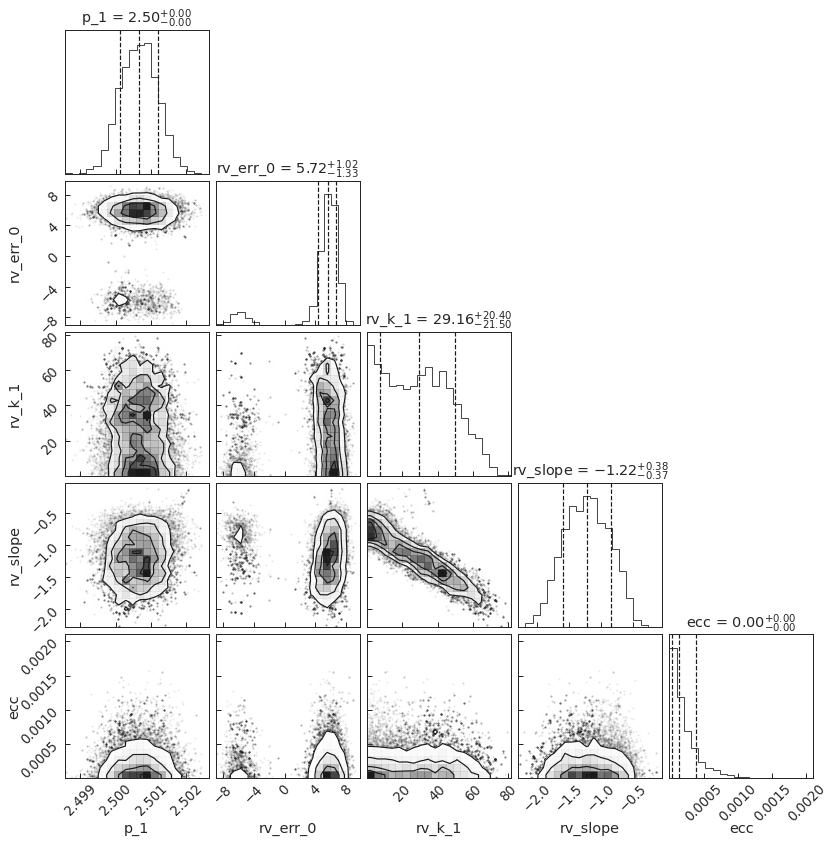

In [31]:
from corner import corner

plt.rcParams['font.size'] = 14

cols = 'p_1 rv_err_0 rv_k_1 rv_slope ecc'.split()
fig = corner(df2[cols], labels=cols, show_titles=True, quantiles=[0.16,0.50,0.84]);

In [32]:
pv = df2.median().values
pv

array([ 2.45951927e+06,  2.50065937e+00,  3.36350490e-04, -1.18517369e-03,
        2.84777546e+01,  5.72100109e+00,  2.91614732e+01, -1.21750623e+00,
        1.45305985e-04,  5.35713205e+00])

In [33]:
t0=pv[0]
p=pv[1]
k=pv[6]
e=ecc(pv[2],pv[3])
w=omega(pv[2],pv[3])
offset =pv[4]

N=500
t=np.linspace(df.bjd.min(),df.bjd.max(),N)
rv = rv_model(t, t0, p, e, w, k, offset)
rv[:10]

array([23.7989096 , 38.37445995, 50.45626887, 57.00005007, 56.35695116,
       48.68900651, 35.92831857, 21.29024367,  8.4632212 ,  0.67937096])

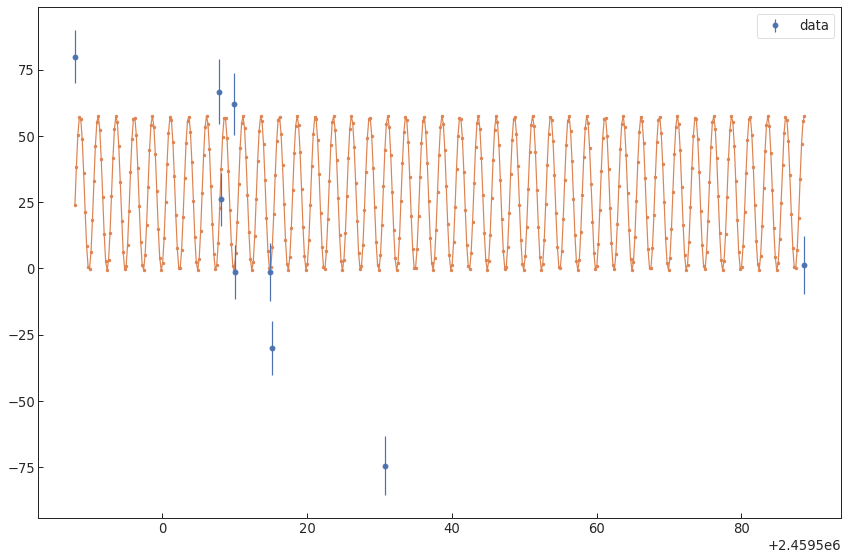

In [34]:
fig, ax = plt.subplots(figsize=(12,8))

rve = np.sqrt(df['rv_err']**2+pv[5]**2)
ax.errorbar(df['bjd'], df['rv'], rve, fmt='o', label='data', zorder=10)
plt.plot(t, rv, '.-')
plt.legend()
fig.tight_layout()

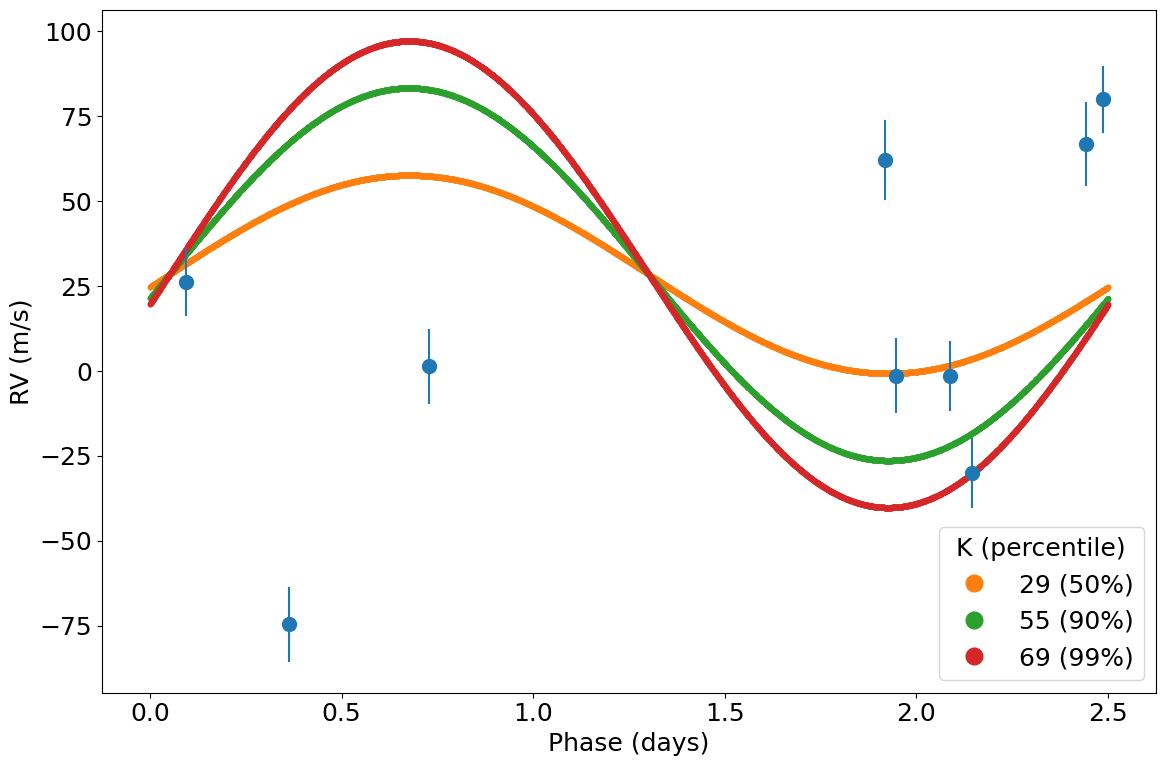

In [35]:
plt.style.use('default')
plt.rcParams['font.size'] = 18

fig, ax = plt.subplots(figsize=(12,8))

N = 5000
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase = t % Porb[0]
idx = np.argsort(phase)
ax.errorbar(df['bjd'] % Porb[0], df['rv'], rve, fmt='o', ms=10, zorder=10)

pctls = [50,90,99]
ks = np.percentile(df2.rv_k_1, pctls)
for k,i in zip(ks, pctls):
    rv = rv_model(t, t0, Porb[0], e, w, k, offset)
    ax.plot(phase[idx], rv[idx], '.', label=f'{k:.0f} ({i}%)')
    
plt.legend(title='K (percentile)', markerscale=4)
plt.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)')
fig.tight_layout()

In [36]:
import astropy.units as u
import astropy.constants as c
from uncertainties import unumpy
import matplotlib.pyplot as pl

Mstar = (0.255, 0.007)
Mp = (10,1)
Ms_samples = np.random.rand(N)*Mstar[1]+Mstar[0]
mp_samples = np.ones_like(Ms_samples)
Porb_samples = np.random.rand(N)*Porb[1]+Porb[0]
inc_samples = np.ones_like(Ms_samples)*90

Kmax = (df2.rv_k_1.max()-df2.rv_k_1.min())/2
K_samples = np.random.uniform(df2.rv_k_1.std(), Kmax, len(Ms_samples))
e_samples = np.random.uniform(0, 0.01, len(Ms_samples))

In [37]:
def get_Mp_from_K(Porb_samples, Ms_samples, K_samples, e=e_samples, inc=inc_samples):
    """
    """
    P = Porb_samples*u.day.to(u.second)*u.second
    Ms = Ms_samples*u.Msun.to(u.kg)*u.kg
    K = K_samples*(u.m/u.second)
    Mp_samples = ((P*Ms**2)/(2*np.pi*c.G))**(1/3)*(K*(1-e**2)**0.5)/np.sin(inc)
    return Mp_samples

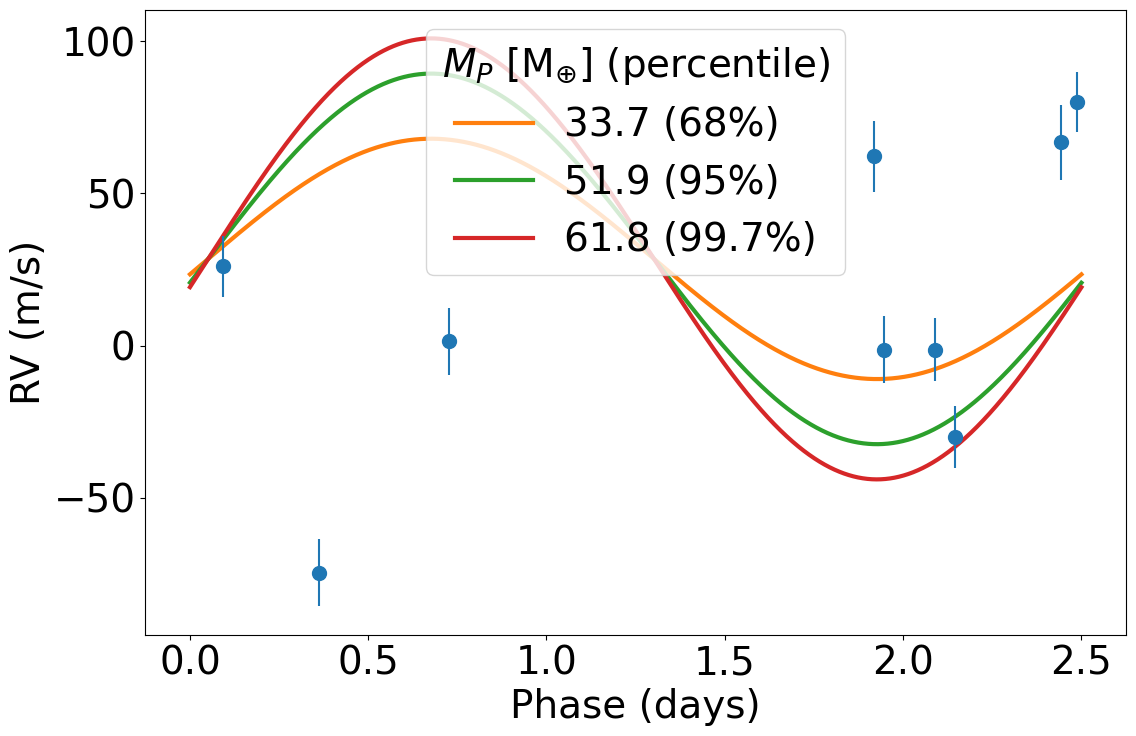

In [38]:
plt.style.use('default')
plt.rcParams['font.size'] = 28

fig, ax = plt.subplots(figsize=(12,8))

N = 5000
t = np.linspace(df.bjd.min(),df.bjd.max(), N)
phase = t % Porb[0]
idx = np.argsort(phase)
ax.errorbar(df['bjd'] % Porb[0], df['rv'], rve, fmt='o', ms=10, zorder=10)

pctls = [68,95,99.7]
ks = np.percentile(df2.rv_k_1, pctls)
for i,k in zip(pctls,ks):
    Mp = get_Mp_from_K(Porb[0], Mstar[0], k, e=0, inc=np.pi/2).to(u.Mearth).value
    rv = rv_model(t, t0, Porb[0], e, w, k, 0)
    ax.plot(phase[idx], rv[idx] + offset, '-', lw=3, label=f'{Mp:.1f} ({i}%)')
plt.legend(title='$M_P$ [M$_{\oplus}$] (percentile)', markerscale=4, loc='upper center')
plt.setp(ax, xlabel='Phase (days)', ylabel='RV (m/s)')
fig.tight_layout()

In [47]:
fig.savefig("../paper/figures/RV_comp.png", bbox_inches="tight")

In [52]:
from astropy import constants as con

In [55]:
71.5 * con.M_earth / con.M_jup

<Quantity 0.22496416>